In [1]:
# Event Rate Simulator
import numpy
import random
import array
import matplotlib.pyplot as plt

TPC_transfer_time = 1/2.8e3                             # time to transfer an event 
TPC_readout_time = 40e-6                                # tpc readout deadtime per buffer

TPC_pipeline_depth = 4                                  # tpc buffer depth
TPC_readout_freetime = 0                                # next time readout can be done
TPC_transfer_freetime = [0.0]*TPC_pipeline_depth        # the time each buffer will be free

def getTimeTillNextEvent(event_rate):
    r = random.random()
    time = -numpy.log(1 - r) / event_rate
    return time

def addEvent(time):
    # assume that the buffer is available!
    global TPC_readout_freetime
    
    # update readout time
    TPC_readout_freetime = time + TPC_readout_time
    
    # find time last transfer will end
    last_transfer_endtime = time
    for i in range(TPC_pipeline_depth):
        if(TPC_transfer_freetime[i] > last_transfer_endtime):
            last_transfer_endtime = TPC_transfer_freetime[i]
        
    # now select a buffer and update the endtime
    for i in range(TPC_pipeline_depth):
        if(TPC_transfer_freetime[i] < time):    # this buffer is available!
            TPC_transfer_freetime[i] = last_transfer_endtime + TPC_transfer_time
            return

def isLive(time):
    # Are we already readingout an event
    if(time < TPC_readout_freetime):
        return False;
    # Not reading out, but is there a free buffer available?
    for i in range(TPC_pipeline_depth):
        if(time > TPC_transfer_freetime[i]):
            return True;
    # No free buffers
    return False

def getRate(ps, physicsRate):
    global TPC_readout_freetime
    TPC_readout_freetime=0
    for i in range(TPC_pipeline_depth):
        TPC_transfer_freetime[i] = 0
        
    checks = 0
    physicsPresent = 0
    live = 0
    events=0
    ps_ctr = ps
    
    totalTime = 1
    time = 0
    while (time < totalTime):
        time += getTimeTillNextEvent(physicsRate);
        physicsPresent += 1
        if(isLive(time)):                           # detector live
            live += 1

            ps_ctr -= 1                               # prescale satisfied!
            if(ps_ctr <= 0):                           
                events += 1
                addEvent(time)            
                ps_ctr += ps
                
    return [events/time, (physicsPresent - live)/physicsPresent]



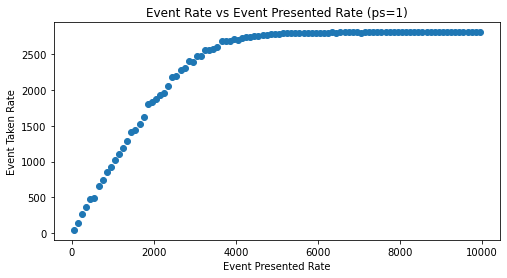

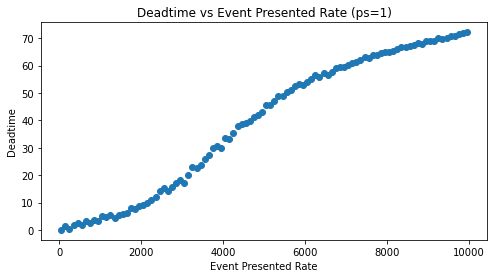

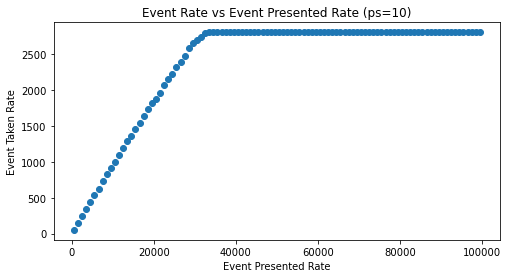

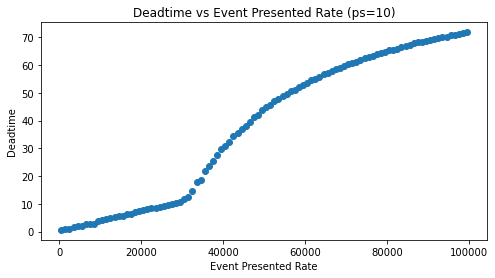

In [2]:
# run event rate simulator

presentedRate1 = []
rate1 = []
deadtime1 = []

presentedRate10 = []
rate10 = []
deadtime10 = []

for physRate in range(50, 10000, 100):
    [mrate, mdeadtime] = getRate(1, physRate)
    presentedRate1.append(physRate)
    rate1.append(mrate)
    deadtime1.append(mdeadtime * 100)
    
    [mrate, mdeadtime] = getRate(10, physRate*10)
    presentedRate10.append(physRate*10)
    rate10.append(mrate)
    deadtime10.append(mdeadtime * 100)
    
plt.figure(1, figsize=(8,4))
plt.title("Event Rate vs Event Presented Rate (ps=1)")
plt.xlabel("Event Presented Rate")
plt.ylabel("Event Taken Rate")
plt.scatter(presentedRate1, rate1)
plt.figure(2, figsize=(8,4))
plt.title("Deadtime vs Event Presented Rate (ps=1)")
plt.xlabel("Event Presented Rate")
plt.ylabel("Deadtime")
plt.scatter(presentedRate1, deadtime1)
    
plt.figure(3, figsize=(8,4))
plt.title("Event Rate vs Event Presented Rate (ps=10)")
plt.xlabel("Event Presented Rate")
plt.ylabel("Event Taken Rate")
plt.scatter(presentedRate10, rate10)
plt.figure(4, figsize=(8,4))
plt.title("Deadtime vs Event Presented Rate (ps=10)")
plt.xlabel("Event Presented Rate")
plt.ylabel("Deadtime")
plt.scatter(presentedRate10, deadtime10)